In [1]:
## Find the exact bounds for \alpha_i for a variance normalized (not mean) distr
p, n, u, K = var('p, n, u, K')
# TODO: FIX ME
errorTerm = 0.56 / (sqrt(p) * (1-p) ^ (1.5) * sqrt(n))
mean = 0#n*p / sqrt(p * (1 - p) * n)
guassian = 1 / sqrt(2 * pi) * e ^ (-0.5 * (u - mean)^2)
# eqSmaller = -errorTerm + (1/u + 1/u^3) * guassian <= K / n
eqLarger = errorTerm + (1/u) * guassian == K / n
((solve([eqLarger], u)))

[u == 25*n^(3/2)*sqrt(p)*(-p + 1)^(3/2)*e^(-1/2*u^2)/(25*sqrt(2)*sqrt(pi)*K*sqrt(n)*sqrt(p)*(-p + 1)^(3/2) - 14*sqrt(2)*sqrt(pi)*n)]

## The actual thing

In [2]:
u, M, K, p, DegBit, DegStab = var('u, M, K, p, NTS, NTQ')

pPrime = 0.5 - 0.5 * (1-2*p)^DegStab
mean = DegBit * DegStab * (pPrime)
stdDev = sqrt(DegBit * DegStab * pPrime * (1 - pPrime))
gaussian = 1 / sqrt(2 * pi) * exp(-0.5 * u^2)
errorTerm = 0.56 / sqrt(DegBit * DegStab)

# TODO: THIS ERROR TERM IS GIVING ME SOME TROUBLE...
eqLarger = errorTerm + (1/u) * gaussian == K / M
(solve([eqLarger], u))

[u == 25*sqrt(NTQ*NTS)*M*e^(-1/2*u^2)/(25*sqrt(2)*sqrt(pi)*sqrt(NTQ*NTS)*K - 14*sqrt(2)*sqrt(pi)*M)]

## Using Sage and Order Statistics to plot expected G_k
1. Using the definition of a binomial distribution, get the largest `u` such that Pr[G_k >= u] >= K / N
2. Get the expected value of E_i
3. Plot the differences etc.

In [4]:
0.9^300

1.87392770388481e-14

<>:39: DeprecationWarning: invalid escape sequence \d
<>:39: DeprecationWarning: invalid escape sequence \d
<ipython-input-3-4a97a56d6bc7>:39: DeprecationWarning: invalid escape sequence \d
  legend_label=f"({deg_bit}, {deg_stable}) graph, $\delta = {delta}$, $p = {error_probability}$, $M = {M}$")


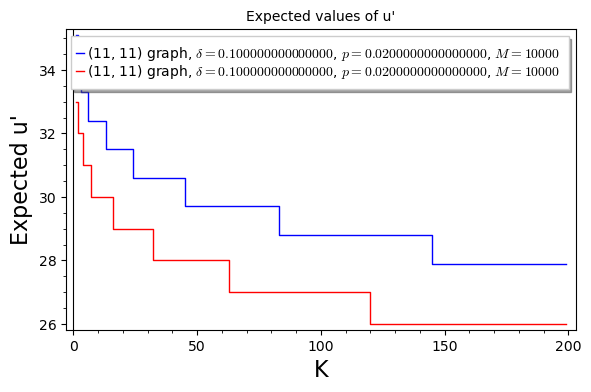

In [3]:
# NCDF refers to 1 - cdf here (i.e. Pr[X >= v] for some v)
# Note it is inclusive

def binomial_pdf(n, p, x):
    return binomial(n, x) * p ^ x * (1 - p) ^ (n-x)


def binomial_ncdf(n, p, x):
    probSum = 0.0
    for i in range(x, n + 1):
        probSum = probSum + binomial_pdf(n, p, i)
    return probSum


def binomial_ncdf_inverse(n, p, targetP):
    for i in range(1, n):
        ncdf_p = binomial_ncdf(n, p, i)
        if ncdf_p < targetP:
            return i - 1
    return n


def get_ncdf_inverse_plotter(deg_bit, deg_stable, error_probability, M, scale=1):
    n = round(deg_bit * deg_stable * scale)
    p = 0.5 - 0.5*(1 - 2 * error_probability) ^ deg_stable
    def f(kTop): return binomial_ncdf_inverse(n, p, kTop / M)
    return f


def get_step_fn_plot(deg_bit, deg_stable, error_probability, M, delta, c, scale=1, domain=(1, 200)):
    ncdf_plotter = get_ncdf_inverse_plotter(
        deg_bit, deg_stable, error_probability, M, scale)
    if scale != 1:
        points = [(k, ncdf_plotter(k)) for k in range(*domain)]
    else:
        points = [(k, (1 - delta) * ncdf_plotter(k)) for k in range(*domain)]
    return plot_step_function(points,
		 	color=c,
			legend_label=f"({deg_bit}, {deg_stable}) graph, $\delta = {delta}$, $p = {error_probability}$, $M = {M}$")


plot_params = [
    (11, 11, 0.02, 10_000, 0.1, 'blue', 1),
    (11, 11, 0.02, 10_000, 0.1, 'red', 1-0.2),
    # (11, 11, 0.015, 10_000, 0.2, 'red'),
    # (11, 11, 0.01, 10_000, 0.2, 'green'),
    # (11, 11, 0.005, 10_000),
]

plots = [get_step_fn_plot(*plot_params[i]) for i in range(0, len(plot_params))]
combined = plots[0]
for i in range(1, len(plots)):
	combined = combined + plots[i]


combined.axes_labels(['K', 'Expected u\''])
combined.legend(True)

combined.show(title='Expected values of u\'', frame=True, legend_loc="upper right")

In [4]:
degBit = 11
degStable = 11
delta = 1/6

# https://stats.stackexchange.com/questions/394960/variance-of-normal-order-statistics
# Variance for quantile
def binomial_inverse_variance(N, p, inverse):
	return p * (1-p) / ((N+1) * (binomial_pdf(N, p, inverse)^2))


# M is # of samples
def order_stat_expectation_dict_gen(N, p, M):
	d = {}
	for i in range(1, M + 1):
		# here k is kth largest value
		inverse_ret = binomial_ncdf_inverse(N, p, i / M)
		# I think this variance here is wrong
		variance = binomial_inverse_variance(N, p, inverse_ret)
		d[i] = (inverse_ret, variance)
	return d

## Lower bound via taking advantage of discrete RV
def chebyshevLowerBound(V, mu, variance):
	stdDevs = ceil(abs(V + 1 - mu) / sqrt(variance))
	if stdDevs == 0:
		return 0.1
	else:
		return (1 / stdDevs^2)

# Uses Chebyshev's bound
# Hmmmmmm ok maybe not and this is wrong
# Basically you have to find a ~lower bound~ for G
# Urrrrrrrrrrrr, we can heuristically use normal distribution bounds here...
def pr_indep_G_E(k, G, E, gDict, p_E, n_E, delta):
	(expectedG, varG) = gDict[k]
	# IDK
	#for now just like guess...
	# Reverse calculate the binomial distribution
	# nqp = varG, p = (1-q), 
	# Welp... ok this is definitely wrong...
	# p1 = (expectedG - varG) / expectedG
	# # TODO: urrr
	# n1 = round(expectedG / p1)
	# prG = binomial_pdf(n1, p1, G)
	prG = 1 if expectedG == G else 0
	# prG = chebyshevLowerBound(G, expectedG, varG)
	prE = binomial_pdf(n_E, p_E, E)
	# print(p1, n1)
	return prG * prE
	
def calc_pr_indep_G_E_gt_v_for_k(bitDeg, stableDeg, delta, v, k, pError, GDict, nG, nE, pE):
	maxG = nG
	maxE = nE
	prGtEqV = 0
	for e in range(0, maxE ):
		for g in range(0, maxG):
			optScore = bitDeg * (((1 - delta) * g - e) / ((1 - delta) * (g + e)))
			if optScore >= v:
				pr = pr_indep_G_E(k, g, e, GDict, pE, nE, delta)
				# print(pr)
				prGtEqV = prGtEqV + pr

	return prGtEqV


# TODO: remove tmp gdict
def calc_pr_indep_G_E_gt_v(bitDeg, stableDeg, delta, v, kRange, pError, M, GDict=None):
	pG = 0.5 - 0.5 * (1 - 2 * pError)^stableDeg
	pE = 0.5 + 0.5 * (1 - 2 * pError)^stableDeg - (1 - pError)^stableDeg
	nG = floor((1 - delta) * bitDeg * stableDeg)
	nE = floor((1 - delta) * bitDeg * stableDeg)

	GDict = GDict if GDict != None else order_stat_expectation_dict_gen(bitDeg * stableDeg, pG, M)
	error_prob = 1
	for k in range(*kRange):
		success_prob = calc_pr_indep_G_E_gt_v_for_k(bitDeg, stableDeg, delta, v, k, pError, GDict, nG, nE, pE)
		print(k, success_prob)
		error_prob = error_prob * (1 - success_prob)
	return (error_prob, GDict)

(error_prob, GDict) = calc_pr_indep_G_E_gt_v(11, 11, 0.3, 1/3, (1, 20), 0.00001, 300, GDict=None)
error_prob

1 0.999999538041735
2 0.999999538041735
3 0.999999538041735
4 0.000000000000000
5 0.000000000000000
6 0.000000000000000
7 0.000000000000000
8 0.000000000000000
9 0.000000000000000
10 0.000000000000000
11 0.000000000000000
12 0.000000000000000
13 0.000000000000000
14 0.000000000000000
15 0.000000000000000
16 0.000000000000000
17 0.000000000000000
18 0.000000000000000
19 0.000000000000000


9.85844059995914e-20

In [5]:
error_prob

9.85844059995914e-20

In [6]:
## NOTES
# It may be best to not use G' and rather just use G until you get to the fraction. 
GDict = None

In [7]:
degBit = 11
degStable = 11
delta = 1/6


def binomial_pdf(n, p, x):
    return binomial(n, x) * p ^ x * (1 - p) ^ (n-x)


def binomial_ncdf(n, p, x):
    probSum = 0.0
    for i in range(x, n + 1):
        probSum = probSum + binomial_pdf(n, p, i)
    return probSum


def binomial_ncdf_inverse(n, p, targetP):
    for i in range(1, n):
        ncdf_p = binomial_ncdf(n, p, i)
        if ncdf_p < targetP:
            return i - 1
    return n


# https://stats.stackexchange.com/questions/394960/variance-of-normal-order-statistics
# Variance for quantile
# TODO: verify
def binomial_inverse_variance(N, p, inverse):
	return p * (1-p) / ((N+2) * (binomial_pdf(N, p, inverse)^2))


# M is # of samples
def order_stat_expectation_dict_gen(N, p, M):
	d = {}
	for i in range(1, M + 1):
		# here k is kth largest value
		inverse_ret = binomial_ncdf_inverse(N, p, i / M)
		# I think this variance here is wrong
		variance = binomial_inverse_variance(N, p, inverse_ret)
		d[i] = (inverse_ret, variance)
	return d

## Lower bound via taking advantage of discrete RV
# where V < mu
def chebyshevLowerBound(V, mu, variance):
	return min(variance / (mu - V)^2, 1)

## Upper bound via taking advantage of discrete RV
# where V > mu and we are looking for Pr[mu < V]
def chebyshevUpperBound(V, mu, variance):
	return 1 - min(variance / (mu - V)^2, 0)



def pr_G_error_given_E(E, degBit, degStable, delta, expectedG, varianceG):
	# The following is assuming that G' >= max(1, G - delta * degBit * (degStable  - 1))
	G_Prime_lb = max(floor(expectedG - delta * degBit * (degStable - 1)), 1)
	if G_Prime_lb == 1:
		# TODO:
		pass
	else:
		# G_for_error = 
		pass
		# TODO: 


	(3 * degBit^2 * degStable * delta + 3 * degBit * E + E - delta * E - 3 * degBit^2 * delta) / (3 * degBit - 1 + delta)
	print(G_for_error)

	# The following is assuming that G' >= (1-delta)G
	# G_for_error = (2 * E - delta * E) / ((3 * degBit - 1 - delta) * (1 - delta))
	# Note: this gives an upper bound for error
	# TODO: equalling expectation here
	if G_for_error == expectedG:
		return 0.1
	elif G_for_error > expectedG:
		return chebyshevUpperBound(G_for_error, expectedG, varianceG)
	else:
		return chebyshevLowerBound(G_for_error, expectedG, varianceG)

def pr_G_and_E_error(n_E, p_E, E, degBit, delta, expectedG, varianceG):
	prE = binomial_pdf(n_E, p_E, E)
	return prE * pr_G_error_given_E(E, degBit, degStable, delta, expectedG, varianceG)


def calc_pr_indep_G_E_lt_v_for_k(degBit, stableDeg, delta, v, k, pError, GDict, nG, nE, pE):
	maxG = nG
	maxE = nE
	prLtV = 0
	for e in range(0, maxE):
		(gExpected, gVariance) = GDict[k]

		# TODO: get the right probability of G equaling its expected value here...
		# This should just be the probability of G being its expected value
		# This because if G does equal 0, you have already run though all the possible
		# places you can correct an error (i.e. you ain't finding an error here)
		# print(gExpected)
		if gExpected == 0:
			prLtV = prLtV * 0.1	
		else:
			prLtV = prLtV + pr_G_and_E_error(nE, pE, e, degBit, delta, gExpected, gVariance)
	return prLtV

def calc_pr_indep_G_E_lt_v(bitDeg, stableDeg, delta, v, kRange, pError, M, GDict=None):
	pG = 0.5 - 0.5 * (1 - 2 * pError)^stableDeg
	pE = 0.5 + 0.5 * (1 - 2 * pError)^stableDeg - (1 - pError)^stableDeg
	nG = floor(bitDeg * stableDeg)
	nE = floor((1 - delta) * bitDeg * stableDeg)

	GDict = GDict if GDict != None else order_stat_expectation_dict_gen(bitDeg * stableDeg, pG, M)
	error_prob = 1
	for k in range(*kRange):
		tmp = calc_pr_indep_G_E_lt_v_for_k(bitDeg, stableDeg, delta, v, k, pError, GDict, nG, nE, pE)
		error_prob = error_prob * tmp
	return (error_prob, GDict)

GDict = None
(error_prob, GDict) = calc_pr_indep_G_E_lt_v(degBit, degStable, delta, 1/6, (1, 200), 0.01, 500, GDict=None)
# ew... you are going to have to show some stuff for how a decreasing "probability" as time goes on is reversed by an increase in M. etc
error_prob
# 500, 1 error, 1.86836309906158e-617
# 5,000, 1 error, 3.26516680338833e-479

IndentationError: expected an indented block (<ipython-input-7-43f11b5b21d4>, line 59)

In [ ]:
K = 100
p = 0.05
M = 1_000

pr_fails = 0
# Hmmmm, you can probably just make a plot where p ~ 1/M
nErrors = round(p * M)
while nErrors != 0:
	(err, _) = calc_pr_indep_G_E_lt_v(degBit, degStable, delta, 1/3, (1, K), p, M, GDict=None)
	pr_fails = pr_fails + err
	nErrors = nErrors - 1
	p = nErrors / M
	print("nErrors", nErrors, "pr fails", pr_fails)
pr_fails

nErrors 49 pr fails 4.93747168413434e-247
nErrors 48 pr fails 1.58287446960753e-246
nErrors 47 pr fails 5.86746794240222e-246
nErrors 46 pr fails 1.25026434549238e-245
nErrors 45 pr fails 3.15771458040473e-245
nErrors 44 pr fails 1.13628966881429e-244
nErrors 43 pr fails 1.57163182332147e-244
nErrors 42 pr fails 7.76389328040216e-244
nErrors 41 pr fails 1.65384195878890e-243
nErrors 40 pr fails 1.23035502305385e-242
nErrors 39 pr fails 2.41775188529079e-242
nErrors 38 pr fails 3.87937154088683e-242
nErrors 37 pr fails 1.33214756020222e-241
nErrors 36 pr fails 4.75019890274844e-241
nErrors 35 pr fails 1.49972029239942e-240
nErrors 34 pr fails 5.73029410319272e-240
nErrors 33 pr fails 7.56718976538981e-240
nErrors 32 pr fails 1.90182673801884e-239
nErrors 31 pr fails 5.80065463353447e-238
nErrors 30 pr fails 9.53758704703329e-238
nErrors 29 pr fails 1.43676860537945e-237


In [ ]:
floor(-1.2)

-2